In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.metrics import silhouette_score

In [ ]:
data = pd.read_csv("/content/Online Retail.csv")
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'] = data['InvoiceDate'].dt.date
data

<ipython-input-153-5aed90d28add>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France


In [ ]:
# remove rows with missing values
data = data.dropna()

data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Feature Engineering

In [ ]:
#Create a new DataFrame to group informations by customer
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
new_data = {
    # The number of Invoices per Customer
    'Number of Invoices': data.groupby('CustomerID')['InvoiceNo'].nunique(),

    # The average number of items in each invoice per cuntomer
    'Average Basket Size': data.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].sum().groupby('CustomerID').mean(),

    # The total spending per customer
    'Total Spending': data.groupby('CustomerID')['TotalPrice'].sum(),

    # The date of the recent invoice per customer
    'Recent Invoice' : data.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate'].max().groupby('CustomerID').last(),

    # The country of the customer
    'Country': data.groupby('CustomerID')['Country'].first(),

    # list of invoices per customer
    'History': data.groupby('CustomerID')['InvoiceNo'].unique()
}

customers_data = pd.DataFrame(new_data)

customers_data

<ipython-input-155-db565b0bf076>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalPrice'] = data['Quantity'] * data['UnitPrice']


,Number of Invoices,Average Basket Size,Total Spending,Recent Invoice,Country,History
CustomerID,,,,,,
12346.0,2,0.000000,0.00,2011-01-18,United Kingdom,"[541431, C541433]"
12347.0,7,351.142857,4310.00,2011-12-07,Iceland,"[537626, 542237, 549222, 556201, 562032, 57351..."
12348.0,4,585.250000,1797.24,2011-09-25,Finland,"[539318, 541998, 548955, 568172]"
12349.0,1,631.000000,1757.55,2011-11-21,Italy,[577609]
12350.0,1,197.000000,334.40,2011-02-02,Norway,[543037]
...,...,...,...,...,...,...
18280.0,1,45.000000,180.60,2011-03-07,United Kingdom,[545712]
18281.0,1,54.000000,80.82,2011-06-12,United Kingdom,[556464]
18282.0,3,32.666667,176.60,2011-08-09,United Kingdom,"[562525, C562808, 580173]"


# PCA

In [ ]:
X = customers_data[['Number of Invoices','Average Basket Size','Total Spending']]
y = ['Country']

scaler = StandardScaler()
x_scl = StandardScaler().fit_transform(X)
x_scl.shape

(4372, 3)

In [ ]:
dim_red = PCA(n_components=2)
x_pca = dim_red.fit_transform(x_scl)
x_pca.shape

(4372, 2)

In [ ]:
dim_red.components_

array([[ 0.64795363,  0.30511386,  0.69789801],
       [-0.3834157 ,  0.92236532, -0.04727175]])

In [ ]:
dim_red.explained_variance_ratio_

array([0.54304908, 0.32358225])

In [ ]:
dim_red.get_feature_names_out()

array(['pca0', 'pca1'], dtype=object)

In [ ]:
data_pca=pd.DataFrame(x_pca,columns=dim_red.get_feature_names_out())

# Determining Optimal Number of Clusters

# wcss

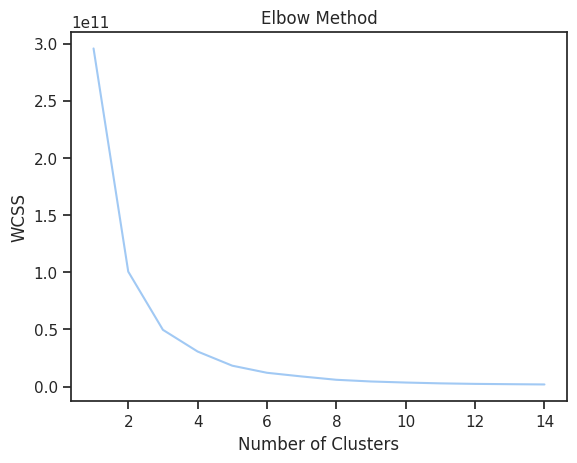

In [ ]:
wcss = []
for n in range(1,15):
    kmeans = KMeans(n_clusters=n, n_init=n, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 15), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

#silhouette

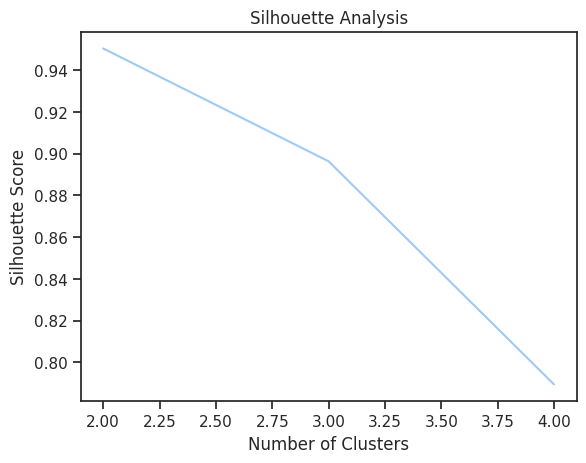

In [ ]:
silhouette_scores = []

for n in range(2, 5):
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(data_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 5), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# KMeans

In [ ]:
# # n_cluster = 3
#km = KMeans(n_clusters=3,n_init=n, random_state=24)
#data_pca.columns = data_pca.columns.astype(str)
#prediction = km.fit_predict(data_pca)

#data_pca['Cluster'] = prediction
#plt.scatter(data_pca.iloc[prediction==0,0],data_pca.iloc[prediction==0,1],color='gray')
#plt.scatter(data_pca.iloc[prediction==1,0],data_pca.iloc[prediction==1,1],color='blue')
#plt.scatter(data_pca.iloc[prediction==2,0],data_pca.iloc[prediction==2,1],color='orange')

#plt.title('Clusters')
#plt.show()


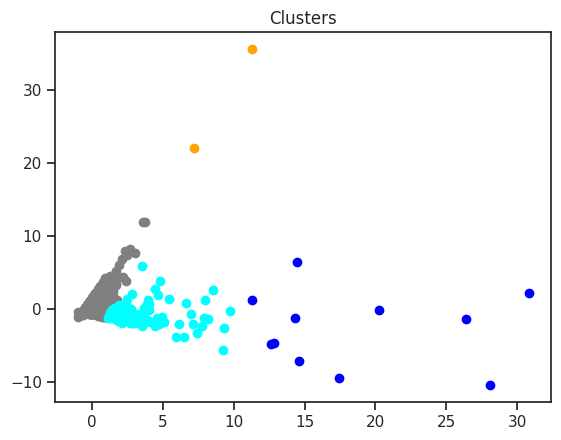

In [ ]:
# # n_cluster = 4
km = KMeans(n_clusters=4,n_init=n, random_state=42)
prediction = km.fit_predict(data_pca)

data_pca.columns = data_pca.columns.astype(str)
data_pca['Cluster'] = prediction
plt.scatter(data_pca.iloc[prediction==0,0],data_pca.iloc[prediction==0,1],color='gray')
plt.scatter(data_pca.iloc[prediction==1,0],data_pca.iloc[prediction==1,1],color='blue')
plt.scatter(data_pca.iloc[prediction==2,0],data_pca.iloc[prediction==2,1],color='orange')
plt.scatter(data_pca.iloc[prediction==3,0],data_pca.iloc[prediction==3,1],color='cyan')


plt.title('Clusters')
plt.show()


In [ ]:
# n_cluster = 5
#km = KMeans(n_clusters=5,n_init=n, random_state=42)
#data_pca.columns = data_pca.columns.astype(str)
#prediction = km.fit_predict(data_pca)

#data_pca['Cluster'] = prediction
#plt.scatter(data_pca.iloc[prediction==0,0],data_pca.iloc[prediction==0,1],color='gray')
#plt.scatter(data_pca.iloc[prediction==1,0],data_pca.iloc[prediction==1,1],color='blue')
#plt.scatter(data_pca.iloc[prediction==2,0],data_pca.iloc[prediction==2,1],color='orange')
#plt.scatter(data_pca.iloc[prediction==3,0],data_pca.iloc[prediction==3,1],color='cyan')
#plt.scatter(data_pca.iloc[prediction==4,0],data_pca.iloc[prediction==4,1],color='black')
#plt.title('Clusters')
#plt.show()


# Cluster Profiling

In [ ]:
np.random.seed(42)
data = pd.DataFrame({
    'CustomerID': range(1, 101),
    'TotalSpending': np.random.randint(100, 1000, 100),
    'OrderFrequency': np.random.randint(1, 20, 100),
    'Recency': np.random.randint(1, 365, 100),
    'AverageBasketSize': np.random.randint(1, 10, 100),
    'Cluster': np.random.randint(0, 4, 100)  # Assuming 4 clusters
})

# Calculate cluster profiles
cluster_profile = data.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'OrderFrequency': 'mean',
    'Recency': 'mean',
    'AverageBasketSize': 'mean'
}).reset_index()

print(cluster_profile)

   Cluster  TotalSpending  OrderFrequency     Recency  AverageBasketSize
0        0     560.555556        9.925926  182.629630           4.555556
1        1     532.000000        9.464286  180.892857           4.750000
2        2     491.777778       10.888889  179.166667           4.444444
3        3     553.962963        6.740741  215.185185           5.074074


# Visualization

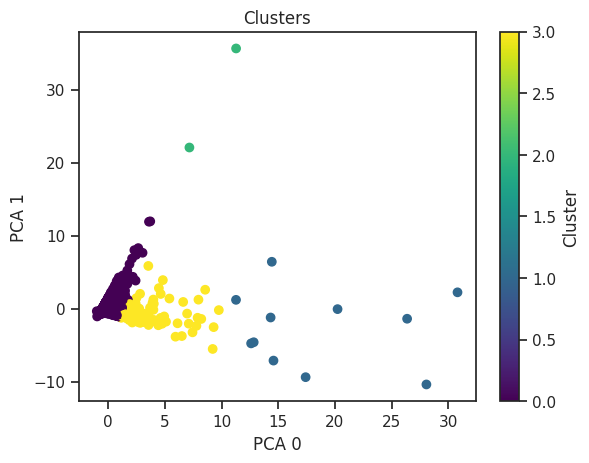

In [ ]:
pca_features= data_pca.values
Cluster = data_pca['Cluster']

plt.scatter(pca_features[:, 0], pca_features[:, 1], c=Cluster, cmap='viridis')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.title('Clusters')
plt.colorbar(label='Cluster')
plt.show()

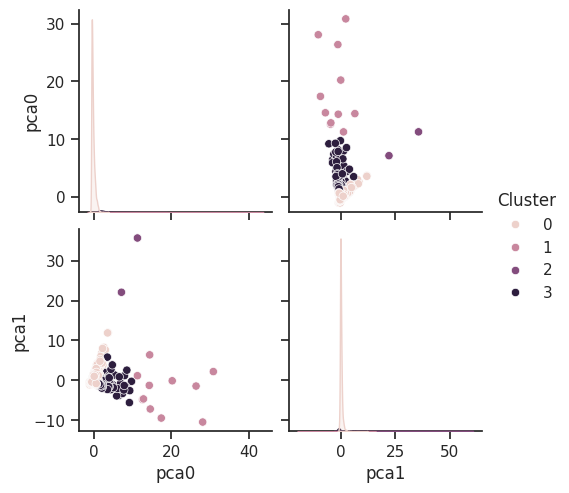

In [ ]:
sns.set(style="ticks", palette="pastel")

sns.pairplot(data_pca, hue="Cluster")

plt.show()

# Evaluation

In [ ]:
#Evaluate the cluster results by wcss
wcss = kmeans.inertia_
print("WCSS:", wcss) #When the WCSS value is lower, the clusters are more tightly grouped

#Evaluate the cluster results by silhouette
silhouette_avg = silhouette_score(data_pca, cluster_labels)
print("Silhouette Score:", silhouette_avg)


WCSS: 1839886753.700059
Silhouette Score: 0.789461052642338


***Personalization and Recommendations:***



**Gray Cluster (New Customers):**

1-Welcome emails with introductory discounts

2-Offer free shipping on first purchase

**Blue Cluster (Favorite Customers):**

1-Personalized loyalty rewards program

2-VIP customer service

**Orange Cluster (Intermediated  Customers):**

1-Personalized product recommendations based on browsing history

2-Send personalized emails suggesting products that go well with their previous purchases

3-bonuses

**Cyan Cluster (Possibly Price-sensitive Customers):**

1-Create a special section on the website featuring "Today's Best Deals" to attract these budget-conscious shoppers.


***Interpretation and Insights:***



**Customer Groups:**

Identified four distinct customer groups. Each group likely has different shopping behaviors and preferences.

**Groups Characteristics:**

Some customer groups are very different from each other, while others have some similarities.
We've found two main factors that help explain these differences, probably related to things like how often customers buy and how much they spend.


**Marketing Insights:**

We can now create targeted marketing campaigns for each customer group.
For example, we might offer different promotions or highlight different products for each group.
This targeted approach should make our marketing more effective and efficient.

**Customer Loyalty:**


We can develop specific strategies to keep customers in each group happy and loyal.
For our best customers, we might create a special loyalty program.
For less frequent shoppers, we could focus on encouraging them to buy more often.


**Stock Management:**


By understanding what each group tends to buy, we can stock our inventory more efficiently.
This could help us avoid overstocking items that don't sell well and ensure we have enough of popular products.


**Website Personalization:**


We can customize our website for each group, showing them products and offers they're most likely to be interested in.
This should improve the shopping experience.


**Future Steps:**


We should update this analysis regularly to keep up with changing customer behaviors.
These insights will help us experiment with different strategies to see what works best for each group.